# 2023-10-20 More about aperture photometry

In [1]:
from astropy.modeling.models import Gaussian2D
from astropy.stats import gaussian_sigma_to_fwhm

from matplotlib import pyplot as plt

import numpy as np

from photutils.profiles import RadialProfile, CurveOfGrowth

In [2]:
def image_with_pixels_labeled(image, **text_kwargs):
    image_size = image.shape[0]
    plt.imshow(image)
    plt.colorbar()
    for i in range(image_size):
        for j in range(image_size):
            plt.text(i, j, int(image[j, i]),
                     fontweight='bold',
                     horizontalalignment='center',
                     verticalalignment='center',
                     **text_kwargs
                    )
            plt.scatter(i, j, marker='.', c='red', alpha=0.5)


In [3]:
def image_with_pixels_labeled(image, pix_precision=0, center_dots=True, ax=None, fig=None, **text_kwargs):
    image_size = image.shape[0]
    if ax is None:
        ax = plt.gca()
    if fig is not None:
        fig = plt.gcf()
    ima = ax.imshow(image)
    if fig is not None:
        fig.colorbar(ima, ax=ax)
    number_format = '{:.' + f'{pix_precision:d}' + 'f}'
    for i in range(image_size):
        for j in range(image_size):
            ax.text(i, j, number_format.format(image[j, i]),
                     fontweight='bold',
                     horizontalalignment='center',
                     verticalalignment='center',
                     **text_kwargs
                    )
            if center_dots:
                ax.scatter(i, j, marker='.', c='red', alpha=0.5)


In [4]:
def circle(x, y, radius):
    angle = np.linspace(0, 2 * np.pi)
    return x + radius * np.cos(angle), y + radius * np.sin(angle)

In [5]:
rng = np.random.default_rng(seed=548975)

In [6]:
figure_size = (20, 20)
graph_size = (10, 10)
image_size = 25
star_center = (12, 12)
background_center = 200
sigma = 2  # Gaussian width of the star
background_image = rng.poisson(lam=background_center, size=[image_size, image_size])

In [7]:
circ = circle(*star_center, 2.1)

In [8]:

fwhm = sigma * gaussian_sigma_to_fwhm

star = Gaussian2D(amplitude=200, x_stddev=sigma, y_stddev=sigma)
grids = np.mgrid[0:image_size, 0:image_size]
star_grid = star(grids[0] - star_center[0], grids[1] - star_center[1])

In [9]:
real_star = rng.poisson(star_grid)

In [10]:
new_background_image = rng.poisson(lam=200, size=[image_size, image_size])

real_image = new_background_image + real_star

In [15]:
rprof = RadialProfile(real_image, star_center, np.arange(18))
radii = []
data = []
for rad, ap in zip(rprof.radius, rprof.apertures):
    ap_mask = ap.to_mask(method='center')
    ap_im = ap_mask.to_image(shape=real_star.shape)
    ap_data = ap_im * real_image
    good_data = ap_im != 0
    data.extend(ap_data[good_data].flatten())
    radii.extend([rad] * good_data.sum())

In [22]:
an_ap = rprof.apertures[1]

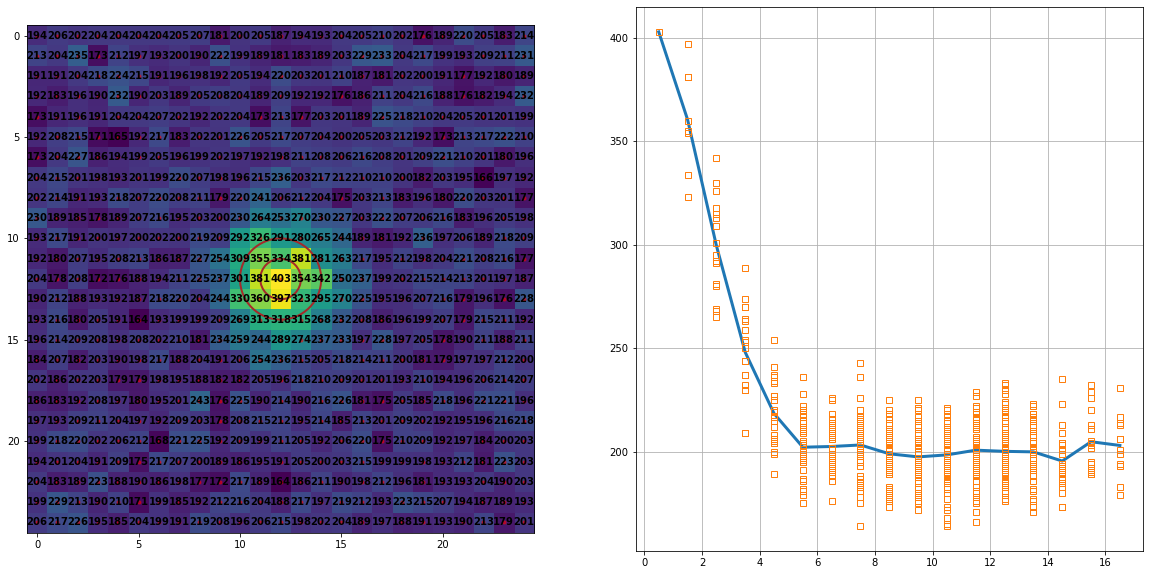

In [24]:
rprof = RadialProfile(real_image, star_center, np.arange(18), method='center')

fig, axs = plt.subplot_mosaic([['im', 'prof']], figsize=(20, 10))

image_with_pixels_labeled(real_image, center_dots=True, ax=axs['im'])
an_ap.plot(ax=axs['im'], color='brown', linewidth=2)

axs['prof'].plot(rprof.radius, rprof.profile, linewidth=3)
axs['prof'].plot(radii, data, 's', markerfacecolor='none', )

axs['prof'].grid()